# Анализ и прогнозирование жизненного цикла стартапов

# Описание проекта

Данный проект представляет собой комплексное исследование в области анализа данных и машинного обучения, направленное на прогнозирование статуса технологических стартапов. В рамках работы проводится анализ исторических данных о 53 000 стартапах, основанных в период с 1980 по 2018 год. 

Проект выполняется в рамках образовательной программы Яндекс Практикума с использованием современных методов Data Science. Результаты исследования имеют практическую ценность для венчурных инвесторов, бизнес-ангелов и предпринимательского сообщества.

# Цель проекта
 
- Разработать модель машинного обучения для предсказания продолжения деятельности стартапа. 
- Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

# Исходные данные

Датасет состоит из двух файлов (+пример с выгрузкой): тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

- kaggle_startups_train.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- kaggle_startups_test.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Задача проекта - предсказать значение 'status' для каждого стартапа из этого датасета.
- kaggle_startups_sample_submit.csv - файл с примером предсказаний в правильном формате.
- name - идентификатор (название) стартапа в тестовом наборе.
- status - целевой признак. Для каждого стартапа нужно предсказать категориальное значение соответствующее прогнозу ['operating', 'closed'].


## Загрузка данных
### Загрузка необходимых библиотек

In [1]:
!pip install -U scikit-learn -q

In [2]:
!pip install shap -q

In [3]:
# Импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from datetime import datetime  # Работа с датами и временем

# загружаем класс pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# дополнительные классы для преобразования данных
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.impute import SimpleImputer

RANDOM_STATE = 22

### Загрузка исследуемых таблиц

In [4]:
try:
    data_train = pd.read_csv('kaggle_startups_train_28062024.csv')
    print(f'Файл kaggle_startups_train_28062024.csv успешно загружен')
except:
    print('Не удалось загрузить таблицу с тестовыми данными')
    
try:
    data_test = pd.read_csv('kaggle_startups_test_28062024.csv')
    print(f'Файл kaggle_startups_test_28062024.csv успешно загружен')
except:
    print('Не удалось загрузить таблицу с тестовыми данными')

Файл kaggle_startups_train_28062024.csv успешно загружен
Файл kaggle_startups_test_28062024.csv успешно загружен


Так же сразу помсмотрим на общую информацию загруженных таблиц

In [5]:
data_dic = {
    'трениров.': data_train, 
    'тест.' : data_test
}

for key in data_dic:
    print(f'=== Общая информация {key} выборки ===')
    print(data_dic[key].info())
    print()
    print(f'=== Описательная статистика для числовых признаков {key} выборки ===')
    print(data_dic[key].describe())
    print()
    print(f'=== Пропущенныйе значения в {key} выборке ===')
    print(data_dic[key].isnull().sum())
    print()

=== Общая информация трениров. выборки ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB
None

=== Описательная статистика для числовых признаков трениров

Выводы по данным:

**Количество признаков данных** - тренировочная выборка состоит из 53 000 записей и 11 признаков, в то время как в тестовой выборке 13 000 записей, но 10 признаков(не берем в счет столбец `name` и `status`). Это обусловлено отсутсвием столбца `lifetime` в тренировочной выборке. Далее будет реализовано его добавление в выборку. 

**Пропущенные значения**  - в обоих наборах данных есть большое количество пропусков в некоторых столбцах - эти пропуски нужно будет обработать. Предположительно можно будет заменить значения наиболее встречающимися или воспользоваться другими способами

**Описательная статистика данных** - Данные показывают разнообразное распределение


### Визуализация пропусков в наборах данных

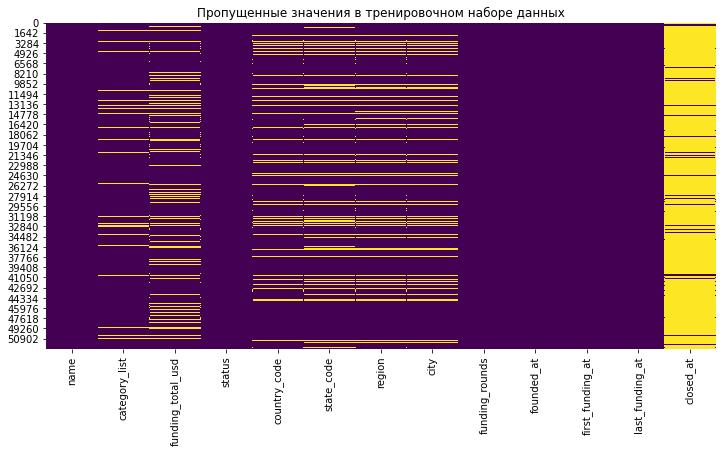

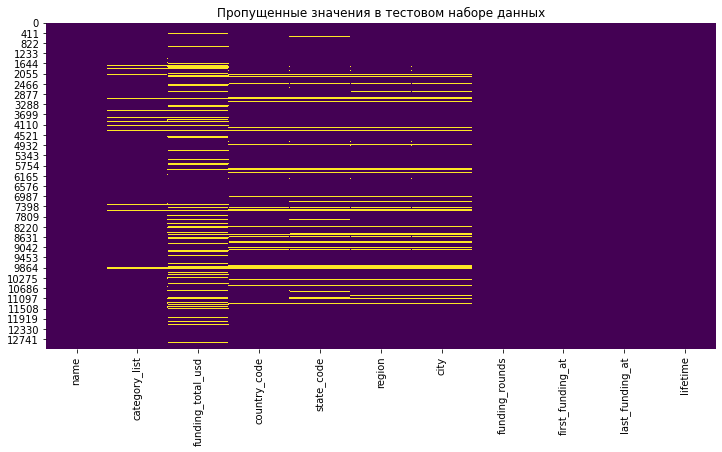

In [6]:
# Визуализация пропусков в тренировочном наборе данных
plt.figure(figsize=(12,6))
sns.heatmap(data_train.isnull(), cbar=False, cmap='viridis')
plt.title('Пропущенные значения в тренировочном наборе данных')
plt.show()

# Визуализация пропусков в тестовом наборе данных
plt.figure(figsize=(12,6))
sns.heatmap(data_test.isnull(), cbar=False, cmap='viridis')
plt.title('Пропущенные значения в тестовом наборе данных')
plt.show()

Можно увидеть множество пропусков в различных столбцах. Однако больше всего  пропусков в столбце closed at. Это можно объяснить либо тем, что компания все еще работает либо тем, что данных об этом нет. 

Для начала добавим признак `lifetime` в тренировочную выборку

In [7]:
def create_lifetime(row, cutoff_date):
    try:
        founded_at = datetime.strptime(row['founded_at'], '%Y-%m-%d')
    except:
        return (cutoff_date - datetime.strptime('1970-01-01', '%Y-%m-%d')).days
    if pd.notnull(row['closed_at']):
        try:
            closed_at = datetime.strptime(row['closed_at'], '%Y-%m-%d')
            return (closed_at - founded_at).days
        except:
            return (cutoff_date - founded_at).days
    else:
        return (cutoff_date - founded_at).days
    
cutoff_date = datetime.strptime('2018-01-01', '%Y-%m-%d')

data_train['lifetime'] = data_train.apply(lambda row: create_lifetime(row, cutoff_date), axis=1)

Так же заполним по возможности все остальные пропуски в обоих датасетах. Для начала выделим количественные и категориальные признаки.

In [8]:
cat_features = ['category_list', 'country_code', 'state_code', 'region', 'city']

num_features = ['funding_total_usd', 'funding_rounds', 'lifetime']

Заполним пропуски - для количественных значений поставим медианные значения. Пропуски в категориальных признаках заменим значением 'Unknown', поскольку не ясна природа возникновения пропусков

Единственным пропуском, который не будет заполнен, является пропуск в признаке `name` в тренировочном датасете. Строку с этим пропуском удалим.

In [9]:
numeric_imputer = SimpleImputer(strategy='median')
data_train[num_features] = numeric_imputer.fit_transform(data_train[num_features])
data_test[num_features] = numeric_imputer.transform(data_test[num_features])

categorial_imputer = SimpleImputer(strategy='constant', fill_value='Unknown')
data_train[cat_features] = categorial_imputer.fit_transform(data_train[cat_features])
data_test[cat_features] = categorial_imputer.transform(data_test[cat_features])

data_train = data_train.dropna(subset=['name'])

Убедимся в отсутствии пропусков в выборке

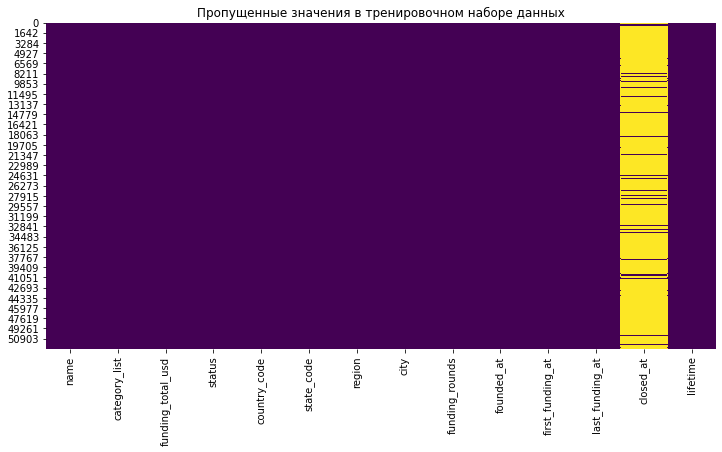

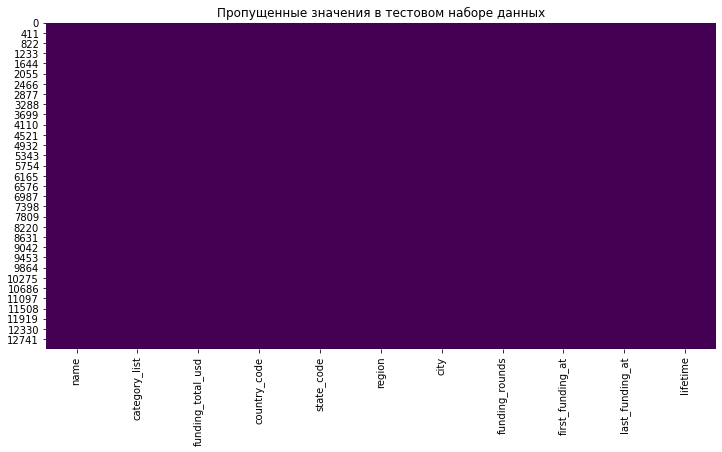

In [10]:
# Визуализация пропусков в тренировочном наборе данных
plt.figure(figsize=(12,6))
sns.heatmap(data_train.isnull(), cbar=False, cmap='viridis')
plt.title('Пропущенные значения в тренировочном наборе данных')
plt.show()

# Визуализация пропусков в тестовом наборе данных
plt.figure(figsize=(12,6))
sns.heatmap(data_test.isnull(), cbar=False, cmap='viridis')
plt.title('Пропущенные значения в тестовом наборе данных')
plt.show()

### Исследование дубликатов в данных

Проверим сколько в данных полностью дублирующихся строк

In [11]:
print(f'Количество полных дубликатов в таблице data_train: {data_train.duplicated().sum()}')

print(f'Количество полных дубликатов в таблице data_test: {data_test.duplicated().sum()}')

Количество полных дубликатов в таблице data_train: 0
Количество полных дубликатов в таблице data_test: 0


Полных дубликатов в выбоках не обнаружено. Однако так же следует проверить наличие дубликатов в столбце `name`, поскольку значения этого столбца должны быть уникальны для каждой строки

In [12]:
data_train_name_duplcated = data_train.duplicated(subset='name').sum()

print(f'Количество полных дубликатов в столбце name: {data_train_name_duplcated}')

Количество полных дубликатов в столбце name: 0


Дубликатов в столбце `name` также не обнаружено

## Разведочный анализ данных
### Добавление новых признаков

Для анализа признаков использовать столбцы дат(например `founded_at` и `closed_at`) неудобно. Поэтому добавим новые столбцы, для того, чтобы лучше можно было анализировать даты. Из каждого столбца с датой возьмем только год. 

In [13]:
train_analysis = data_train.copy()
test_analysis = data_test.copy()
# Добавление нового признака, чтобы потом отделить выборки друг от друга
train_analysis['type'] = 'train'
test_analysis['type'] = 'test'
# Объединение выборок для удобства создания новых признаков
full_analysis = pd.concat([train_analysis, test_analysis], ignore_index=True)

#Преобразование данных в тип datetime
for col in ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']:
    full_analysis[col] = pd.to_datetime(full_analysis[col], errors='coerce')

full_analysis['founded_at'] = full_analysis['founded_at'].dt.year
full_analysis['first_funding_at'] = full_analysis['first_funding_at'].dt.year
full_analysis['last_funding_at'] = full_analysis['last_funding_at'].dt.year
full_analysis['closed_at'] = full_analysis['closed_at'].dt.year

# Разделение выборок, для будущего анализа
train_analysis = full_analysis[full_analysis['type'] == 'train']
test_analysis = full_analysis[full_analysis['type'] == 'test']

In [14]:
test_analysis.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime,type
52515,Crystalsol,Clean Technology,2819200.0,NaN,NIC,17,Unknown,Unknown,1.0,NaN,2009,2009,NaN,3501.0,test
52516,JBI Fish & Wings,Hospitality,2000000.0,NaN,USA,TN,TN - Other,Humboldt,1.0,NaN,2010,2010,NaN,2717.0,test
52517,COINPLUS,Finance,428257.0,NaN,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2.0,NaN,2014,2014,NaN,1295.0,test
52518,Imagine Communications,Software|Video|Video Streaming,34700000.0,NaN,USA,CA,San Diego,San Diego,4.0,NaN,2005,2010,NaN,4748.0,test
52519,DNA13,Software,4530000.0,NaN,CAN,ON,Ottawa,Ottawa,1.0,NaN,2007,2007,NaN,6209.0,test


### Анализ количественных признаков

Визуализируем распределения признаков, для их анализа.

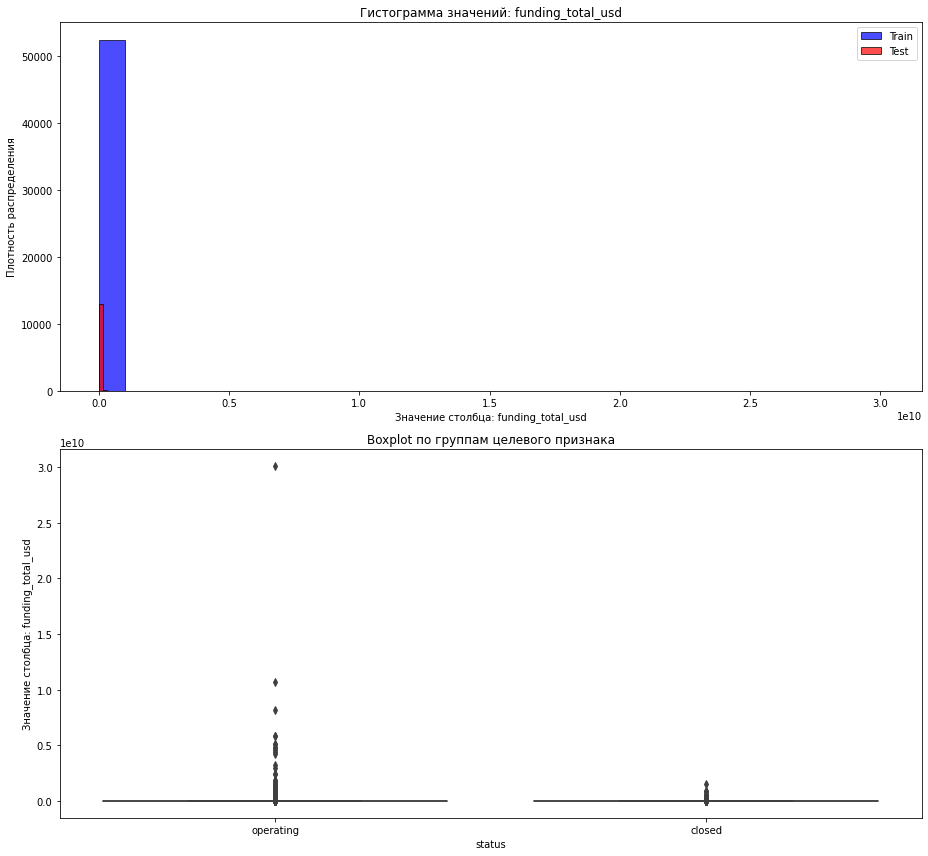

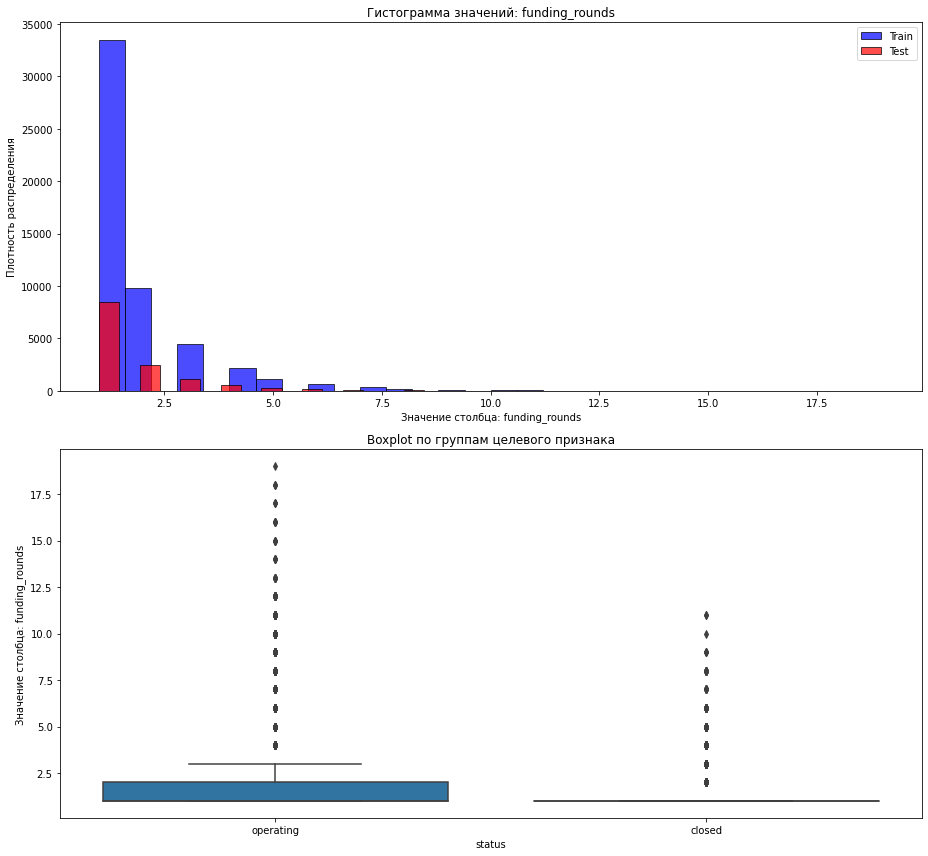

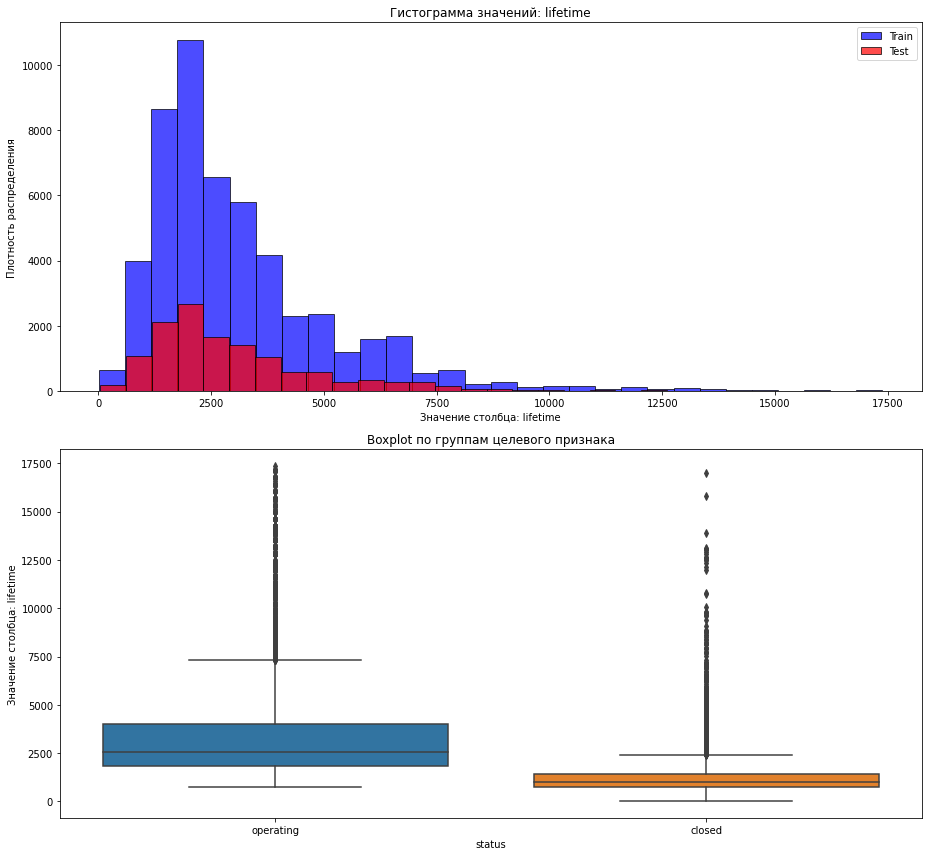

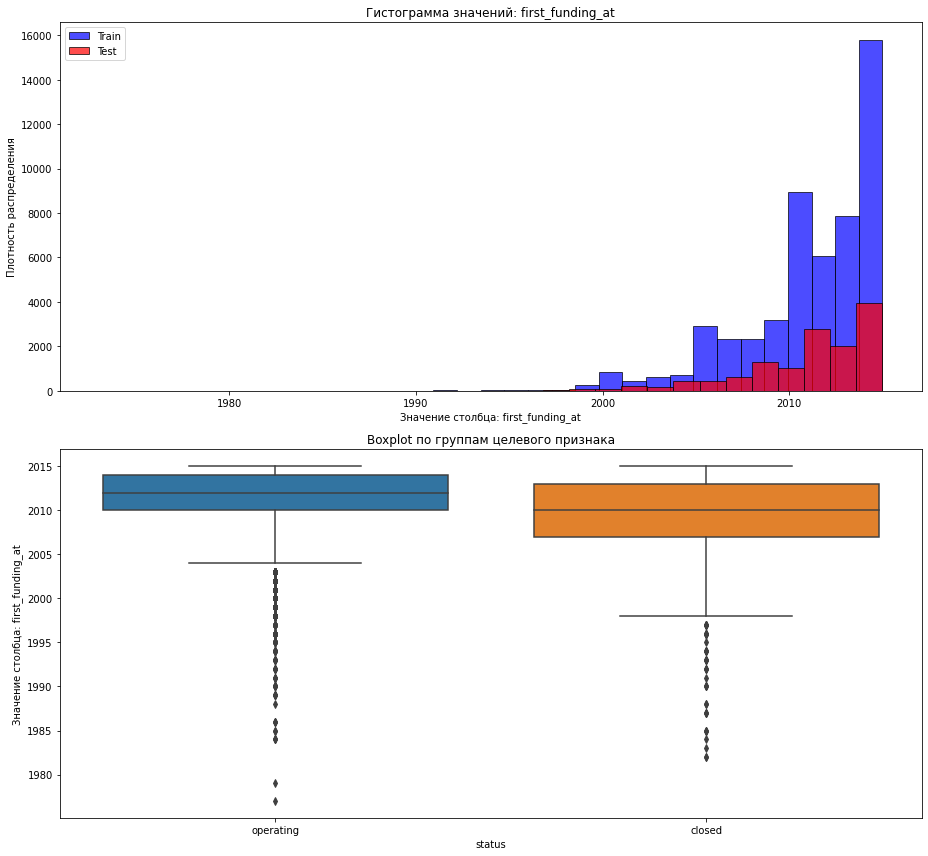

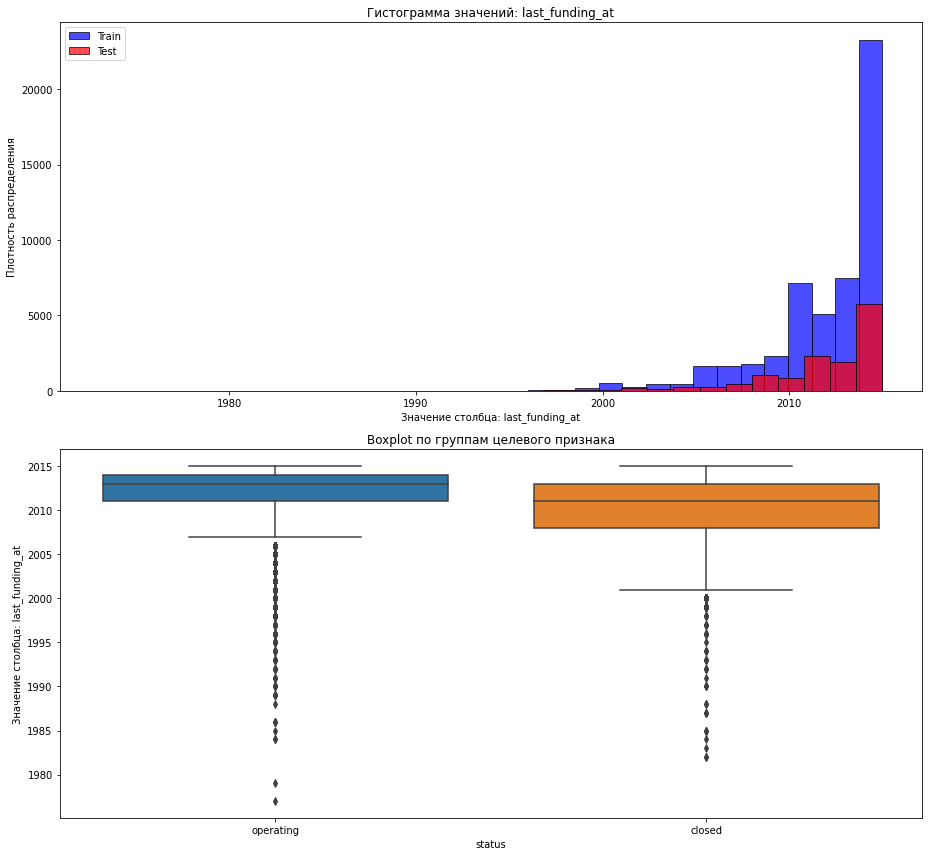

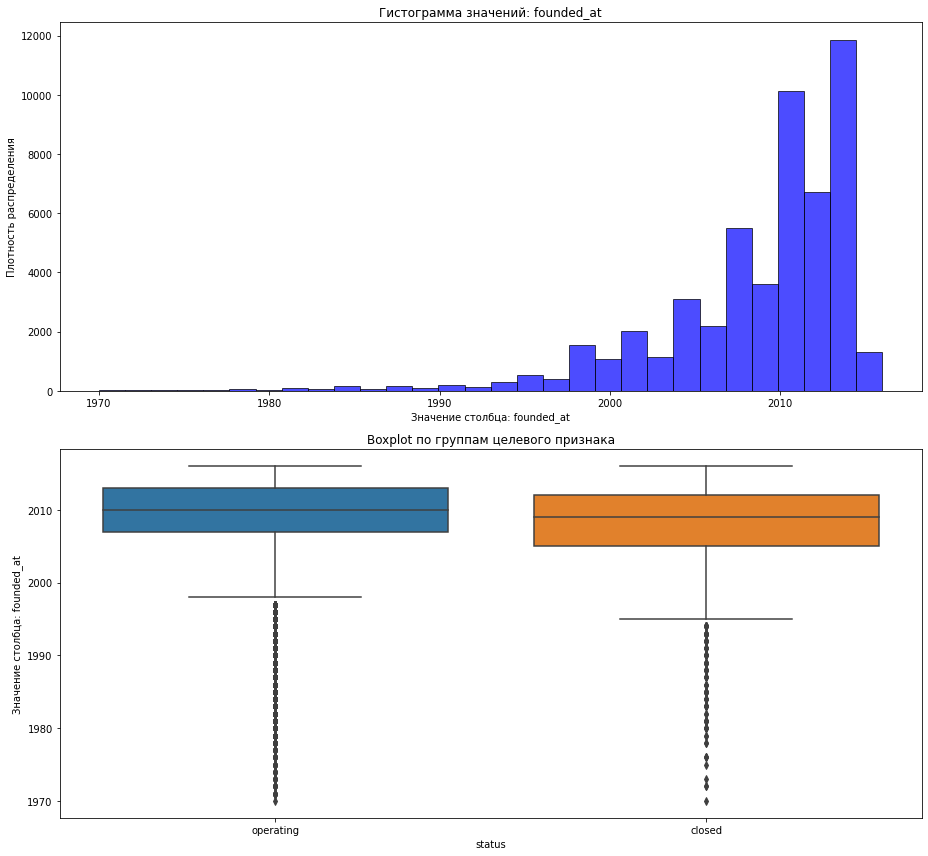

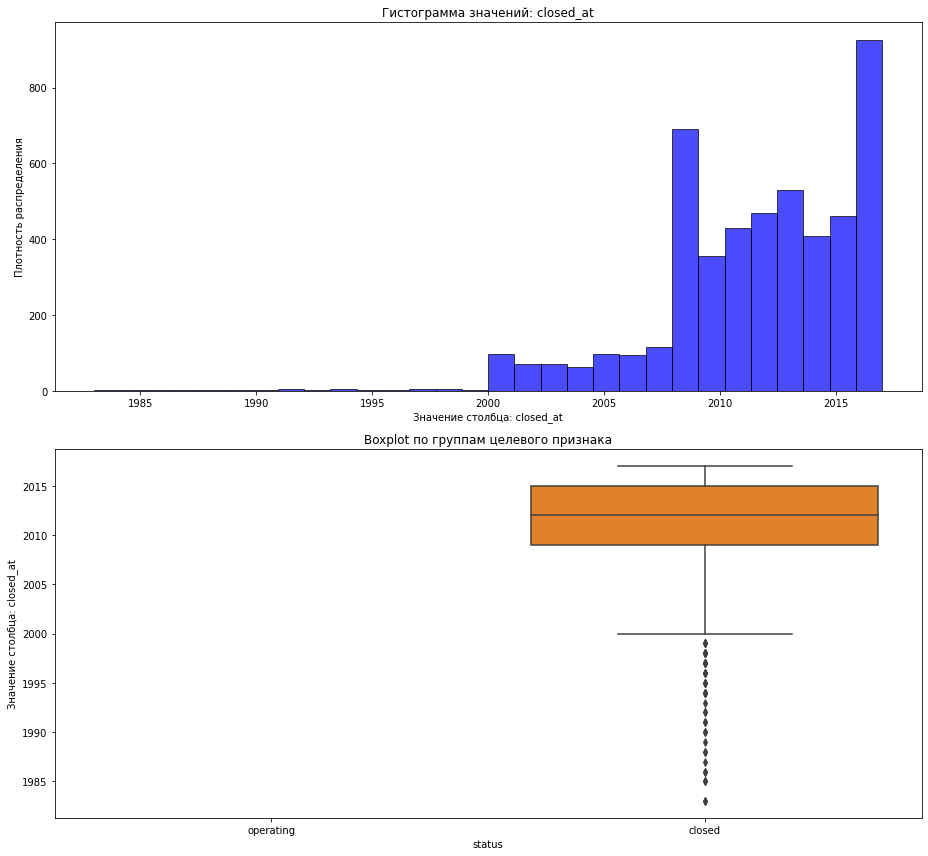

In [15]:
def hist_boxplot_two_df(column_train, column_test, column_full, target_column):  # Функция для построения гистограмм и диаграмм размаха
    plt.figure(figsize=(13, 12))
    
    # Гистограмма
    plt.subplot(2, 1, 1)
    plt.title(f'Гистограмма значений: {column_train.name}')
    plt.xlabel(f'Значение столбца: {column_train.name}')
    plt.ylabel('Плотность распределения')
    plt.hist(column_train, bins=30, color='blue', edgecolor='black', alpha=0.7, label='Train')
    plt.hist(column_test, bins=30, color='red', edgecolor='black', alpha=0.7, label='Test')
    plt.legend()
    
    # Boxplot по группам целевого признака
    plt.subplot(2, 1, 2)
    plt.title(f'Boxplot по группам целевого признака')
    sns.boxplot(x=target_column, y=column_full)
    plt.xlabel('status')
    plt.ylabel(f'Значение столбца: {column_train.name}')
    
    plt.tight_layout()
    plt.show()
    
    
def hist_boxplot_one_df(column, target_column):
    plt.figure(figsize=(13, 12))
    # Гистограмма
    plt.subplot(2, 1, 1)
    plt.title(f'Гистограмма значений: {column.name}')
    plt.xlabel(f'Значение столбца: {column.name}')
    plt.ylabel('Плотность распределения')
    plt.hist(column, bins=30, color='blue', edgecolor='black', alpha=0.7)

    
    # Boxplot по группам целевого признака
    plt.subplot(2, 1, 2)
    plt.title(f'Boxplot по группам целевого признака')
    sns.boxplot(x=target_column, y=column)
    plt.xlabel('status')
    plt.ylabel(f'Значение столбца: {column.name}')
    
    plt.tight_layout()
    plt.show()

num_features =  ['funding_total_usd', 'funding_rounds', 'lifetime', 'first_funding_at', 'last_funding_at', 'founded_at', 'closed_at']
    
full_analysis_num_columns = ['funding_total_usd', 'funding_rounds', 'lifetime', 'first_funding_at', 'last_funding_at']

for column in full_analysis_num_columns:
    hist_boxplot_two_df(train_analysis[column], test_analysis[column], full_analysis[column], train_analysis['status'])
    
train_analysis_num_column = ['founded_at', 'closed_at']

for column in train_analysis_num_column:
    hist_boxplot_one_df(train_analysis[column], train_analysis['status'])

***Разведывательный анализ данных (EDA)***

* 1. `funding_total_usd`
- Большинство стартапов имеют небольшое финансирование.
- Действующие стартапы чаще имеют более высокое финансирование (много выбросов).
- **Вывод:** высокая сумма инвестиций положительно коррелирует с выживаемостью.


* 2. `funding_rounds`
- Наиболее частое значение — 1–3 раунда.
- Действующие стартапы имеют больше раундов, чем закрытые.
- **Вывод:** количество раундов — важный признак устойчивости компании.


* 3. `lifetime`
- Действующие стартапы живут дольше (медиана выше).
- **Вывод:** продолжительность жизни напрямую связана с вероятностью быть активным.


* 4. `first_funding_at` и `last_funding_at`
- Активные стартапы получили финансирование позже, чем закрытые.
- **Вывод:** дата последнего финансирования — важный временной индикатор.


* 5. `founded_at`
- Большинство стартапов основано после 2005 года.
- Закрытые чаще были основаны раньше.
- **Вывод:** более молодые стартапы чаще ещё активны.


* Общие замечания:
- Распределения асимметричны — полезно применить лог-преобразования.
- Признаки `lifetime`, `funding_total_usd`, `funding_rounds`, `last_funding_at` — ключевые для модели.


### Анализ качественных признаков
Для начала определим количественные признаки и посмотрим на их количество в каждом столбце

In [16]:
cat_analysis_features = ['category_list', 'country_code', 'region', 'city']

for column in cat_analysis_features:
    amount_category = full_analysis[column].nunique()
    print(f'Количество уникальных значений в столбце {column}: {amount_category}')

Количество уникальных значений в столбце category_list: 27070
Количество уникальных значений в столбце country_code: 138
Количество уникальных значений в столбце region: 1091
Количество уникальных значений в столбце city: 5056


Количество уникальных наименований в каждом признаке довольно велико. Поэтому будем брать в рассчет только первые 15 категорий, остальный отнесем в отдельную общую категорию

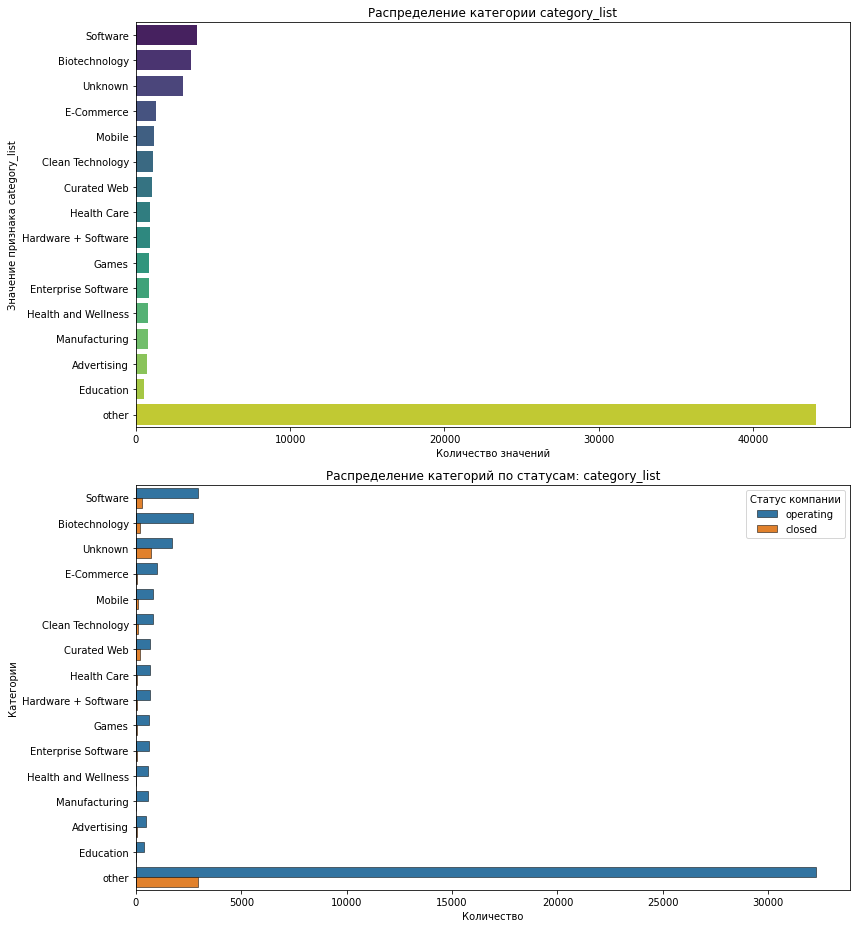

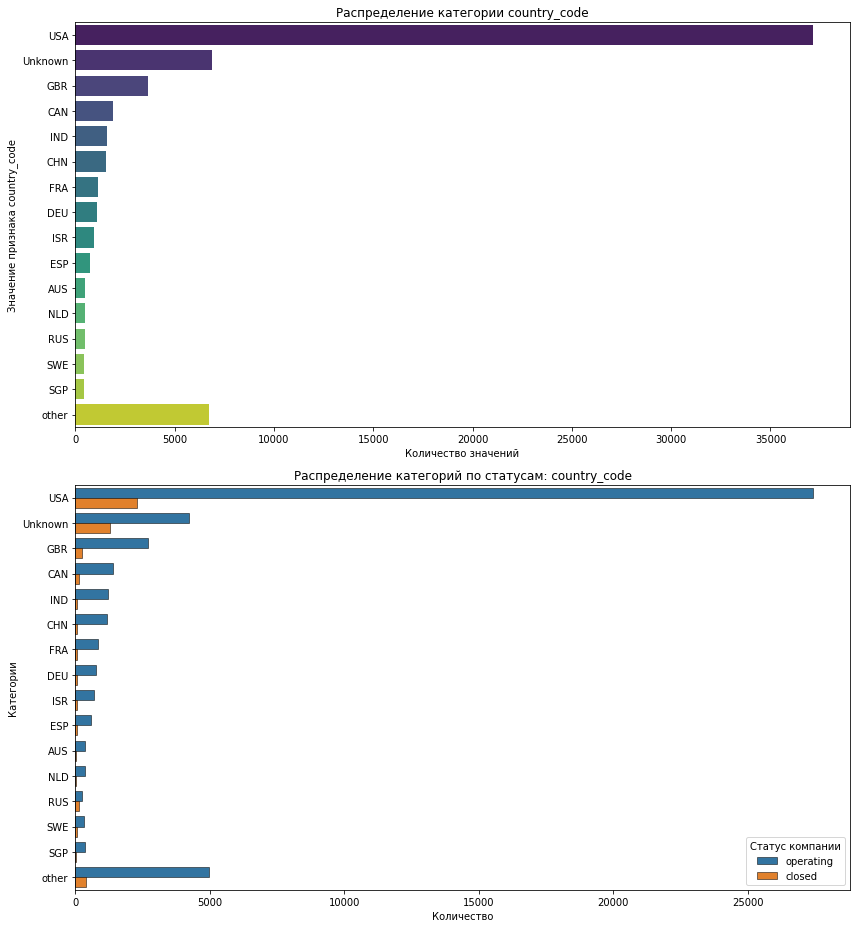

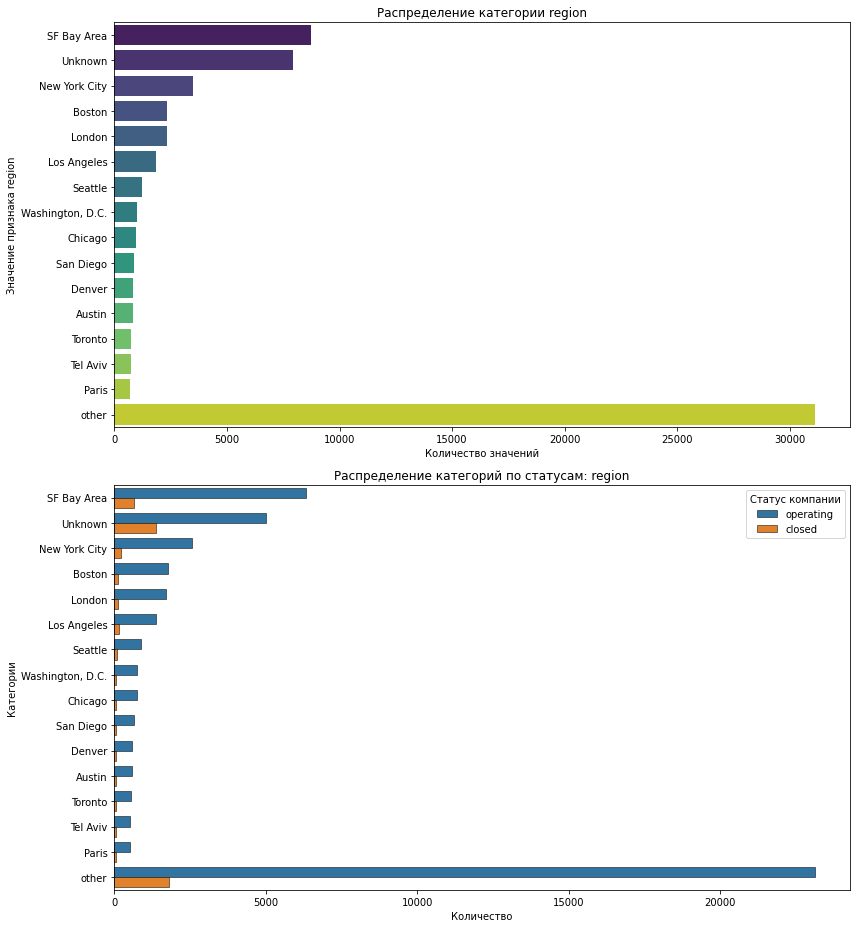

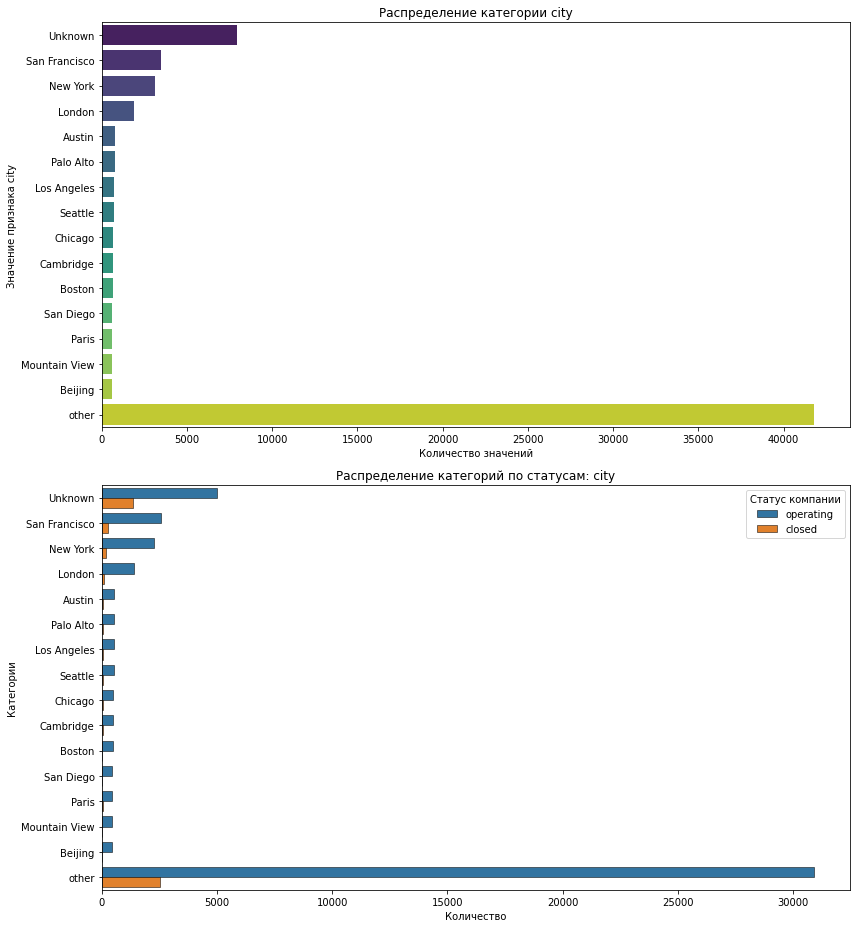

In [17]:
top_n = 15

def countplot_cat(column, target_column):
    plt.figure(figsize=(12, 13))  # Поменяли размеры для лучшего отображения
    plt.subplot(2, 1, 1)
    # Заменяем редкие значения на 'other'
    top_values = column.value_counts().head(top_n).index
    column_grouped = column.where(column.isin(top_values), 'other')
    
    # Сортируем по убыванию (кроме 'other')
    value_counts = column_grouped.value_counts()
    sorted_categories = value_counts[value_counts.index != 'other'] \
                          .sort_values(ascending=False) \
                          .index.tolist()
    sorted_categories.append('other')  # 'other' всегда в конце
    
    # Рисуем ГОРИЗОНТАЛЬНЫЙ график (заменили x на y)
    sns.countplot(
        y=column_grouped,  # Изменили x на y для горизонтальной ориентации
        palette='viridis',
        order=sorted_categories
    )
    
    plt.title(f'Распределение категории {column.name}')
    plt.ylabel(f'Значение признака {column.name}')  # Поменяли xlabel на ylabel
    plt.xlabel("Количество значений")  # Поменяли ylabel на xlabel
    plt.tight_layout()  # Добавили для корректного отображения подписей
    
    plt.subplot(2, 1, 2)
    # Создаем DataFrame для построения графика
    plot_data = pd.DataFrame({
        'category': column_grouped,
        'status': target_column
    })    
    # Сортируем категории по частоте (по убыванию), кроме 'other'
    category_order = plot_data['category'].value_counts() \
                       .loc[lambda x: x.index != 'other'] \
                       .sort_values(ascending=False) \
                       .index.tolist()
    category_order.append('other')  # 'other' всегда в конце
    
    # Строим группированный countplot
    sns.countplot(
        y='category',
        hue='status',
        data=plot_data,
        order=category_order,
        palette={'operating': '#1f77b4', 'closed': '#ff7f0e'},  # Цвета для каждого статуса
        edgecolor='black',
        linewidth=0.5
    )
    
    plt.title(f'Распределение категорий по статусам: {column.name}')
    plt.ylabel('Категории')
    plt.xlabel('Количество')
    plt.legend(title='Статус компании')
    plt.tight_layout()
    plt.show()

for column in cat_analysis_features:
    countplot_cat(full_analysis[column], train_analysis['status'])

* Анализ категориальных признаков

* `category_list`
  - Наиболее частые категории: `other`, `Software`, `Biotechnology`, `Unknown`.
  - Наибольшее количество действующих стартапов наблюдается в категориях `Software`, `Biotechnology`, `E-Commerce`.
  - **Вывод:** категориальный признак значим для модели. Стартапы в технологических и биомедицинских категориях чаще продолжают работу.


* `country_code`
  - Большинство стартапов зарегистрировано в США, далее следуют Великобритания, Канада, Индия.
  - В США наблюдается более высокая доля действующих компаний.
  - **Вывод:** страна регистрации оказывает влияние на статус компании. Стартапы из США демонстрируют лучшую выживаемость.


* `region`
  - Популярные регионы: SF Bay Area, New York City, Boston, London.
  - В SF Bay Area и NYC преобладают действующие компании.
  - **Вывод:** расположение в крупных технологических центрах повышает шансы на выживание.


* `city`
  - Лидируют: San Francisco, New York, London, Austin, Palo Alto.
  - В городах с развитой стартап-инфраструктурой доля закрытых компаний ниже.
  - **Вывод:** географическое положение на уровне города может служить дополнительным предиктором.


* Общие замечания:
  - Категория `other` используется для объединения редких значений и может сохраняться в модели как универсальный обобщённый класс.
  - Категория `unknown` обозначает отсутствие данных. В ряде случаев (например, `country_code`, `region`) она коррелирует с закрытием стартапов и может быть полезна.
  - Наиболее значимое влияние на целевой признак оказывают следующие категориальные переменные: `category_list`, `country_code`, `region`, так как в них наблюдаются выраженные различия в распределении между статусами `operating` и `closed`.

### Корреляционный анализ признаков
Проведем корреляционный анализ количественных признаков

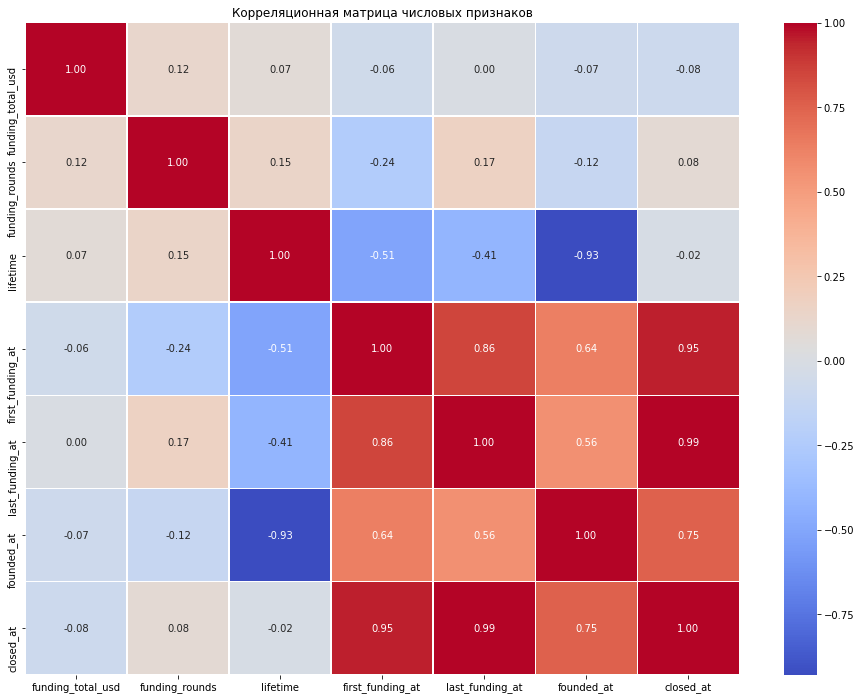

In [18]:
plt.figure(figsize=(16,12))
corr = train_analysis[num_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

* Корреляционный анализ числовых признаков

* `funding_total_usd`
  - Практически не коррелирует с другими признаками.
  - Незначительная положительная связь с `funding_rounds` (0.12) и `lifetime` (0.07).
  - **Вывод:** признак важен скорее сам по себе, а не как часть связанной группы. Может быть полезен для модели из-за индивидуального влияния.


* `funding_rounds`
  - Слабо коррелирует с остальными признаками.
  - Незначительная положительная связь с `lifetime` (0.15) и `last_funding_at` (0.17).
  - **Вывод:** количество раундов финансирования не входит в сильно коррелированные группы и даёт дополнительную информацию.


* `lifetime`
  - Сильно отрицательно коррелирует с датами (`founded_at`: -0.93, `first_funding_at`: -0.51).
  - Это логично: чем позже основана компания — тем меньше её возраст.
  - **Вывод:** `lifetime` — производный признак, несущий ту же информацию, что и даты. Следует избежать одновременного использования с датами во избежание мультиколлинеарности.


* `first_funding_at`, `last_funding_at`, `founded_at`
  - Сильно коррелируют друг с другом и с `closed_at` (от 0.56 до 0.99).
  - **Вывод:** все временные признаки находятся в одной высокой корреляционной группе. В модели стоит выбрать 1–2 наиболее информативных.


* `closed_at`
  - Почти идеально коррелирует с `first_funding_at` (0.95) и `last_funding_at` (0.99).
  - **Вывод:** признак напрямую связан с целевой переменной и отражает момент закрытия компании. Не должен использоваться при обучении модели (утечка целевой информации).


* Общие замечания:
  - Наиболее взаимосвязанные признаки: `first_funding_at`, `last_funding_at`, `founded_at`, `closed_at`.
  - Для устранения избыточности следует исключить один из сильно коррелированных признаков.
  - `funding_total_usd`, `funding_rounds`, `lifetime` — относительно независимые признаки и могут быть полезны при обучении модели без риска мультиколлинеарности.


## Создание синтетических признаков

Исходя из анализа предыдущего пункта было принято решение добавить в выборку следующие признаки

**Финансовые показатели:**
- `funding_per_round` — средний размер финансирования в одном раунде. Вычисляется как отношение `funding_total_usd` к количеству раундов `funding_rounds`. Позволяет оценить интенсивность вложений.
- `has_funding` — бинарный признак, указывающий, привлекал ли стартап финансирование (`1` — да, `0` — нет).

**Временные интервалы:**
- `funding_duration` — продолжительность периода финансирования (в днях), измеряется как разница между датой последнего и первого раунда: `last_funding_at - first_funding_at`.
- `time_since_last_funding` — количество дней, прошедших с последнего раунда финансирования до условной текущей даты (`2018-01-01`). Позволяет оценить, насколько недавно стартап получал инвестиции.

In [19]:
cutoff_date = pd.to_datetime("2018-01-01")

def generate_features(df):
    # Преобразование дат в datetime
    df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
    df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')

    # Финансовые признаки
    df['funding_per_round'] = df['funding_total_usd'] / df['funding_rounds'].replace(0, np.nan)
    df['funding_per_round'] = df['funding_per_round'].fillna(0).astype(int)

    df['has_funding'] = (df['funding_total_usd'] > 0).astype(int)

    # Временные интервалы
    df['funding_duration'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
    df['funding_duration'] = df['funding_duration'].fillna(0)

    df['time_since_last_funding'] = (cutoff_date - df['last_funding_at']).dt.days
    df['time_since_last_funding'] = df['time_since_last_funding'].fillna(0)

    return df

# Применяем к обоим датафреймам
data_train = generate_features(data_train)
data_test = generate_features(data_test)

/tmp/ipykernel_79/883128098.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
/tmp/ipykernel_79/883128098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')
/tmp/ipykernel_79/883128098.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

## Создание пайплайна для поиска модели

Исходя из проанализированных и созданных признаков для обучения модели выберем следующие признаки

* Числовые признаки
     - `funding_total_usd` - Финансовая мощность стартапа — положительно коррелирует с выживаемостью.
     - `funding_rounds` - Количество инвестиций — больше раундов = больше доверия рынка.
     - `funding_per_round` - 	Синтетический признак — уточняет интенсивность вложений.
     - `has_funding` - Бинарный флаг
     - `funding_duration` - Сколько длился период инвестирования — отражает активность.
     - `time_since_last_funding` - Давно ли компания получала средства — может сигнализировать о «заморозке».
     - `lifetime`
     
* Категориальные признаки
    - `category_list` - Сильная зависимость между типом стартапа и выживаемостью.
    - `country_code` - Географический маркер — стартапы из США и развитых стран успешнее.
    - `region` - Более локальный гео-признак
    

In [20]:
num_columns = ['funding_total_usd',
              'funding_rounds',
              'funding_per_round',
              'has_funding',
              'funding_duration',
              'time_since_last_funding']

ohe_columns = ['category_list',
              'country_code',
              'region']

In [21]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(strategy='constant', fill_value='unknown')
            
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]

)

In [22]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Пайплайн для предобработке готов. Напишем пайплайн для перебора гиперпараметров моделей. В качестве рассмтриваемых моделей возьмем Logistic Regression, Random Forest Classifier и Decision Tree Classifier

In [23]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression())
    ]
)

In [24]:
param_grid = [

    # Logistic Regression
    {
        'models': [LogisticRegression(max_iter=1000, solver='liblinear')],
        'models__C': [0.01, 0.1, 1, 10],
        'models__penalty': ['l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]
    },
    
        # Random Forest Classifier
    {
        'models': [RandomForestClassifier(random_state=42)],
        'models__n_estimators': [100, 300],
        'models__max_depth': [None, 5, 10],
        'models__min_samples_split': [2, 5],
        'models__class_weight': ['balanced']
    },


    # Decision Tree Classifier 
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 21, 4)
    }
]

## Обучение модели

Найдем лучшую модель, при этом создав тренировочную и тестовые выборки

In [25]:
# Разделим на признаки и целевую переменную
X = data_train.drop(columns=['name', 'status', 'state_code', 'city', 'founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'])
y = data_train['status']
y = data_train['status'].map({'closed': 1, 'operating': 0})

top_n = 10  # Количество топ категорий для каждого признака
for col in ohe_columns:
    top_categories = X[col].value_counts().nlargest(top_n).index
    X[col] = X[col].apply(lambda x: x if x in top_categories else 'Other')

random_search = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    scoring='f1',
    verbose=2,
    n_jobs=1,
    random_state=RANDOM_STATE
)

random_search.fit(X, y)

# Лучшая модель и параметры
print("Лучшая модель:", random_search.best_estimator_)
print("Лучшие параметры:", random_search.best_params_)
print("Лучшая метрика F1:", random_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=6; total time=   0.2s
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=6; total time=   0.2s
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=6; total time=   0.2s
[CV] END models=RandomForestClassifier(random_state=42), models__class_weight=balanced, models__max_depth=10, models__min_samples_split=5, models__n_estimators=300; total time=   8.1s
[CV] END models=RandomForestClassifier(random_state=42), models__class_weight=balanced, models__max_depth=10, models__min_samples_split=5, models__n_estimators=300; total time=   8.0s
[CV] END models=RandomForestClassifier(random_state=42), models__class_weight=balanced, models__max_depth=10, models__min_samples_split=5, models__n_estimators=300; total time=   7.9s
[CV] END models=DecisionTreeClassifier(random_state=42), models__max_depth=10; total time=   0.3

***Результаты подбора модели***

**Лучшая модель:**
`RandomForestClassifier`, встроенный в `Pipeline` с предварительной обработкой данных.

**Состав финального пайплайна:**
- **Предобработка:**
  - Категориальные признаки (`category_list`, `country_code`, `region`):
    - `SimpleImputer(strategy='constant', fill_value='unknown')`
    - `OneHotEncoder(drop='first', handle_unknown='ignore')`
  - Числовые признаки (`funding_total_usd`, `funding_rounds`, `funding_per_round`, `has_funding`, `funding_duration`, `time_since_last_funding`):
    - `'passthrough'` (признаки использовались без масштабирования)
- **Модель:** `RandomForestClassifier`

**Лучшие параметры:**
- `n_estimators`: 300  
- `min_samples_split`: 5  
- `max_depth`: None  
- `class_weight`: 'balanced'  

**Лучшая метрика F1 (по результатам кросс-валидации):**  
**`0.859`**

## Оценка важности признаков

Проверим как сильно каждый из признаков влияет на выбор модели

In [29]:
X_transformed = random_search.best_estimator_.named_steps['preprocessor'].transform(X)
# Категориальные признаки после OHE
ohe = random_search.best_estimator_.named_steps['preprocessor'].named_transformers_['ohe'].named_steps['ohe']
ohe_feature_names = ohe.get_feature_names_out(ohe_columns)

# Числовые признаки (если были переданы как 'passthrough', то остаются такими)
num_feature_names = num_columns

# Остальные признаки, которые прошли через remainder='passthrough'
used_columns = set(ohe_columns + num_columns)
passthrough_columns = [col for col in X.columns if col not in used_columns]

# Собираем всё вместе
all_feature_names = list(ohe_feature_names) + num_feature_names + passthrough_columns

# Проверяем соответствие
print("Всего признаков:", len(all_feature_names))
print("Трансформированных колонок:", X_transformed.shape[1])

Всего признаков: 37
Трансформированных колонок: 37


In [30]:
X_transformed_df = pd.DataFrame(X_transformed, columns=all_feature_names)

100%|===================| 1995/2000 [05:03<00:00]        

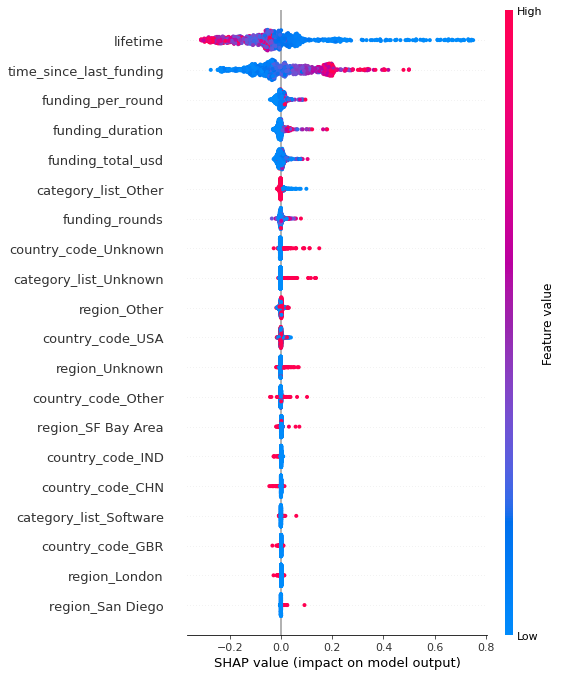

In [31]:
# Для RandomForestClassifier (или другой модели на деревьях) используем TreeExplainer
model = random_search.best_estimator_.named_steps['models']
X_sampled = X_transformed_df.sample(n=1000, random_state=RANDOM_STATE)
explainer = shap.TreeExplainer(model, X_sampled, approximate=True)

# Расчёт SHAP-значений
shap_values = explainer.shap_values(X_sampled)

# Построение графика
shap.summary_plot(shap_values[:, :, 1], X_sampled)

***Интерпретация модели с помощью SHAP***

Анализ SHAP-показателей показал, что наибольшее влияние на предсказание модели оказывают следующие признаки:

- **`lifetime`** — ключевой признак: чем дольше существует стартап, тем меньше вероятность его закрытия.
- **`time_since_last_funding`** — длительное отсутствие инвестиций увеличивает вероятность закрытия.
- **`funding_per_round`** и **`funding_total_usd`** — крупные и частые инвестиции снижают риск закрытия.
- Признаки с неопределёнными значениями (`category_list_Unknown`, `country_code_Unknown`) умеренно повышают риск.
- Географические признаки (`region_SF Bay Area`, `country_code_USA`) оказывают слабозащитное влияние.

В целом модель ориентируется в первую очередь на **временные и инвестиционные показатели**, а также на признаки

##  Выводы

В ходе выполнения исследования были выполнены следующие действия:

---

*Задача: Прогнозирование статуса стартапа (`operating` / `closed`)*

* **1. Загрузка и предобработка данных**
    - Загружены обучающая и тестовая выборки.
    - Удалены неинформативные признаки (`name`, `state_code`, `city` и др.).
    - Обработаны пропуски с помощью `SimpleImputer`.
    - Категориальные признаки закодированы через `OneHotEncoder`.


* **2. Исследовательский анализ данных**
    - Изучены распределения числовых признаков (`funding_total_usd`, `lifetime`, `funding_rounds` и др.).
    - Построены гистограммы и boxplot-графики по статусам компаний.
    - Выявлено, что короткий жизненный цикл, отсутствие инвестиций и редкие раунды чаще связаны с закрытием.
    - Выполнен корреляционный анализ: временные признаки сильно взаимосвязаны между собой.


* **3. Создание новых синтетических признаков**
    Добавлены признаки, усиливающие модель:
    - `funding_per_round` — среднее финансирование за раунд;
    - `has_funding` — индикатор наличия инвестиций;
    - `funding_duration` — длительность привлечения средств;
    - `time_since_last_funding` — время с момента последнего финансирования.


* **4. Обучение моделей и подбор гиперпараметров**
    - Собран пайплайн (`Pipeline + ColumnTransformer`) для автоматизации процесса.
    - Проведён перебор параметров через `RandomizedSearchCV`.
    - Тестировались модели: `LogisticRegression`, `DecisionTree`, `RandomForest`, `XGBoost`.


* **5. Лучшая модель**
    - Лучшая модель: **`RandomForestClassifier`**
    - Параметры: `n_estimators=300`, `min_samples_split=5`, `class_weight='balanced'`
    - **F1-метрика на кросс-валидации: 0.858**


* **6. SHAP-анализ: Интерпретация модели**
    - Самые значимые признаки:
        - `lifetime` — чем дольше живёт стартап, тем меньше шанс закрытия;
        - `time_since_last_funding` — длительное отсутствие инвестиций повышает риск;
        - `funding_per_round`, `funding_total_usd` — большие объёмы инвестиций снижают риск;
        - `category_list_Unknown`, `country_code_Unknown` — неопределённость повышает вероятность закрытия.

In [ ]:
data = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')
data.head()

In [33]:
X_transformed_df.head()

,category_list_Clean Technology,category_list_Curated Web,category_list_E-Commerce,category_list_Games,category_list_Hardware + Software,category_list_Health Care,category_list_Mobile,category_list_Other,category_list_Software,category_list_Unknown,...,region_Seattle,region_Unknown,"region_Washington, D.C.",funding_total_usd,funding_rounds,funding_per_round,has_funding,funding_duration,time_since_last_funding,lifetime
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-0.084967,0.188660,-0.093672,0.0,1.399217,-0.724957,2998.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.165150,1.643715,0.041402,0.0,1.519751,-0.496749,4748.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.120726,0.916187,0.055604,0.0,0.485773,-0.600629,4383.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.042278,0.916187,-0.002017,0.0,1.023093,-0.613716,5114.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,-0.078009,-0.538868,-0.072917,0.0,-0.503186,0.120803,2791.0


In [44]:
X = data_test.drop(columns=['name','state_code', 'city', 'first_funding_at', 'last_funding_at', ])


top_n = 10  # Количество топ категорий для каждого признака
for col in ohe_columns:
    top_categories = X[col].value_counts().nlargest(top_n).index
    X[col] = X[col].apply(lambda x: x if x in top_categories else 'Other')

y_pred = random_search.predict(data_test)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [45]:
status_pred = ['operating' if x == 0 else 'closed' for x in y_pred]

In [46]:
results = pd.DataFrame({
    'name': data_test['name'],  # Предполагая, что 'name' есть в X_test
    'status': status_pred    # Предсказанный статус
})

In [47]:
results.to_csv('predictions.csv', index=False)

In [48]:
results.head()

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating


In [49]:
import os


In [51]:
from pathlib import Path
import pandas as pd

# Получаем путь к папке ноутбука
notebook_path = Path().absolute()
file_path = notebook_path/'model_predictions.csv'

# Сохраняем файл
results.to_csv(file_path, index=False)

# Создаем ссылку для скачивания
from IPython.display import FileLink
FileLink('model_predictions.csv')

/home/jovyan/work/masterskaya_1/model_predictions.csv